In [ ]:
!pip install pytorch-lightning
!pip install torch-fidelity

In [ ]:
import glob
import os
import PIL
import pickle
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl

import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchmetrics.image.inception import InceptionScore
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor if 'cuda' else torch.FloatTensor


#Importing dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_test = '/content/drive/MyDrive/imagenet-mini/train'
PATH_train= '/content/drive/MyDrive/imagenet-mini/val'


In [ ]:
class Config:
    external_data_size = 6000
    train_size = 5000
    test_size = 2000

    img_size_first = 320
    img_size_second = 320

    L_bias = 1
    L_middle = 50
    ab_bias = 0
    ab_max = 128

    batch_size = 32
    num_epochs = 1000

    clipping_value = 0.01
    n_critic = 5
    lamda = 10.
    kernel_size = 3
    stride = 1
    padding = 1
    LeakyReLU_slope = 0.2
    clipping_value = 0.01

In [ ]:
def load_images(path_dir):
    paths = []
    for root, __, files in os.walk(path_dir):
        info = glob.glob(root+ "/*.JPEG")
        if len(info) != 0:
            paths.append(info)  
    paths =  list(zip(*paths))
    paths = np.reshape(paths,[-1])
    return paths

paths_train = load_images(PATH_train)
paths_test = load_images(PATH_test)
print(len(paths_train),len(paths_test))

In [ ]:
# Train test split
np.random.seed(2005551)
paths_subset = np.random.choice(paths_train, Config.external_data_size, replace=False) # choosing images randomly
random_idxs = np.random.permutation(Config.external_data_size) 
train_idxs = random_idxs[:Config.train_size] # choosing the first train_size as training set
val_idxs = random_idxs[Config.train_size:] 
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

test_paths = np.random.choice(paths_test, Config.test_size, replace=False) 

60


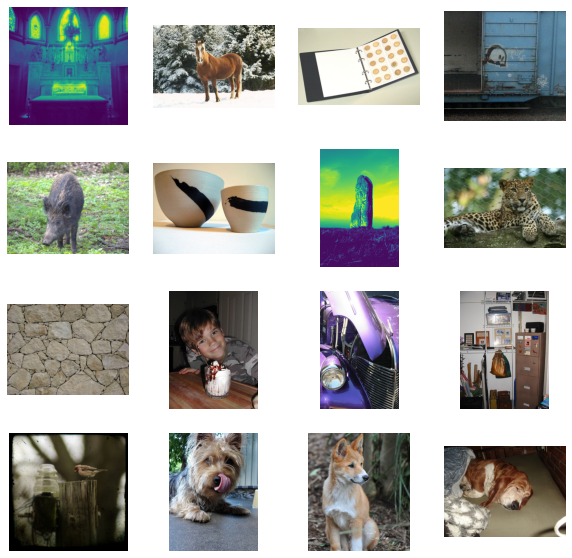

In [ ]:
# Taking a look at the training dataset

_, axes = plt.subplots(4, 4, figsize=(10, 10))
print(len(train_paths))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

#Data preparation

In [ ]:
def make_dataloaders(input,batch_size, n_workers=2, pin_memory=True): 
    dataloader = DataLoader(input, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
class ImageDataset(Dataset):   
    def __init__(self,paths,transforms=None):

        self.transforms = transforms    
        self.paths = paths
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        return img

In [ ]:
class Rgb_to_Lab():
    def __call__(self,x):
        x = np.array(x)
        return rgb2lab(x).astype('float32')

In [ ]:
class Standardize():
    def __init__(self,L_bias=Config.L_bias, L_middle= Config.L_middle, ab_bias=Config.ab_bias, ab_max= Config.ab_max):
        self.L_bias =L_bias
        self.L_middle = L_middle
        self.ab_bias = ab_bias
        self.ab_max = ab_max

    def __call__(self,x):
        L = x[[0],...]/self.L_middle -  self.L_bias
        ab = x[[1,2],...]/self.ab_max  - self.ab_bias

        return {'L':L,'ab':ab}

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((Config.img_size_first,Config.img_size_second)),transforms.RandomHorizontalFlip(),Rgb_to_Lab(),transforms.ToTensor(),Standardize()])
valid_transforms = transforms.Compose([transforms.Resize((Config.img_size_first,Config.img_size_second)),Rgb_to_Lab(),transforms.ToTensor(),Standardize()])
test_transforms  = valid_transforms

In [ ]:
batch_size = Config.batch_size
#train dataset
train_data = ImageDataset(paths = train_paths, transforms =train_transforms)
# validation dataset
valid_data = ImageDataset(paths = val_paths, transforms=valid_transforms)
# train data loader
train_loader = make_dataloaders(train_data, batch_size=batch_size)
# validation data loader
valid_loader = make_dataloaders(valid_data, batch_size=batch_size)

In [ ]:
test_data = ImageDataset(paths = test_paths, transforms=test_transforms)
test_loader = make_dataloaders(test_data, batch_size=batch_size)

#Making the Generator and Discriminator


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, Config.kernel_size, Config.stride, Config.padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(Config.LeakyReLU_slope, True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(Config.LeakyReLU_slope, True),
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=2, features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
generator = UNet(in_channels=1, out_channels=2)
bw_image = torch.randn(1, 1, 320, 320)
print('Input shape: {}'.format(bw_image.shape))
colored_image = generator(bw_image)
print('Generator output shape: {}'.format(colored_image.shape))

Input shape: torch.Size([1, 1, 320, 320])
Generator output shape: torch.Size([1, 2, 320, 320])


In [ ]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
          nn.Conv2d(3, d, 4, 2, 1),
          nn.LeakyReLU(Config.LeakyReLU_slope,inplace=True),    
          nn.Conv2d(d, d * 2, 4, 2, 1),
          nn.BatchNorm2d(d * 2),
          nn.LeakyReLU(Config.LeakyReLU_slope,inplace=True), 
          nn.Conv2d(d * 2, d * 4, 4, 2, 1),
          nn.BatchNorm2d(d * 4),
          nn.LeakyReLU(Config.LeakyReLU_slope,inplace=True), 
          nn.Conv2d(d * 4, d * 8, 4, 1, 1),
          nn.BatchNorm2d(d * 8),
          nn.LeakyReLU(Config.LeakyReLU_slope,inplace=True), 
          nn.Conv2d(d * 8, 1, 4, 1, 1)
        )

    # forward method
    def forward(self, x):

        return self.conv(x)

In [ ]:
discriminator = Discriminator()
bw_image = torch.randn(1, 3, 320, 320)
out =discriminator(bw_image)
out.shape

torch.Size([1, 1, 38, 38])

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


#Training the networks

In [ ]:

class GAN(pl.LightningModule):

    def __init__(
        self, 
        lr: float = 0.5e-4,
        b1: float = 0.5,
        b2: float = 0.999,
        model: str = 'patchGAN',


    ):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        # networks
        self.generator =UNet().to(device)
        self.discriminator = Discriminator().to(device)
        self.generator_train_loss = []
        self.discriminator_loss = []
        self.n_critic_counter = 0
        

        if self.model == 'dcGAN':
          self.adverserial_loss = nn.BCEWithLogitsLoss()
          Config.n_critic = 1
        if self.model == 'wGAN':
           Config.n_critic = 5
    



    def _adverserial_loss_real_imgs(self,input):
      valid = Variable(Tensor(input.shape).fill_(1.0), requires_grad=False)
      return self.adverserial_loss(input, valid)
    
    def _adverserial_loss_fake_imgs(self,input):
      fake = Variable(Tensor(input.shape).fill_(0.0), requires_grad=False)
      return self.adverserial_loss(input, fake)
   
    def l1loss(self,x,target):
        return F.l1_loss(x,target)
   
    def forward(self, z):
        return self.generator(z)


        

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))

        return [opt_g, opt_d], []
   
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        self.L, self.ab = batch['L'],batch['ab']
        imgs = torch.cat([self.L, self.ab], dim=1)
        # train generator
        if optimizer_idx == 0 and batch_idx%Config.n_critic ==0:
            # generate images
            ab_out = self(self.L)
            fake_image = torch.cat([self.L, ab_out], dim=1) 
            l1loss = self.l1loss(ab_out,self.ab)
            
            if self.model == 'wGAN':
              g_loss = -torch.mean(self.discriminator(fake_image)) + l1loss*Config.lamda
            else:
              g_loss = self._adverserial_loss_real_imgs(self.discriminator(fake_image)) + l1loss*Config.lamda
            
            self.log("l1loss", l1loss, prog_bar=True)
            self.log("gen_loss", g_loss, prog_bar=True)
            return {'loss': g_loss, 'optimizer_idx': optimizer_idx, 'gray_image':  None, 'fake_image':  None, 'true_image': None}

            
                                       
      # train discriminator

        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            ab_out = self(self.L)

            fake_image = torch.cat([self.L, ab_out], dim=1)
            
            if self.model == 'wGAN':
              d_loss = -torch.mean(self.discriminator(imgs)) + torch.mean(self.discriminator(fake_image))
              for p in self.discriminator.parameters():
                p.data.clamp_(-Config.clipping_value, Config.clipping_value)
            else:
              d_loss = self._adverserial_loss_real_imgs(self.discriminator(imgs))*0.5 + self._adverserial_loss_fake_imgs(self.discriminator(fake_image))*0.5
            
            self.log("d_loss", d_loss, prog_bar=True)
            return  {'loss': d_loss, 'optimizer_idx': optimizer_idx, 'gray_image':  self.L[0].detach().cpu(), 'fake_image': fake_image[0].detach().cpu(), 'true_image':  imgs[0].detach().cpu()}
          

    def validation_step(self, batch, batch_idx=None):
          # validation_step defines the validation loop. It is independent of forward
          L,ab = batch['L'],batch['ab']
          imgs = torch.cat([L, ab], dim=1)         
          ab_out = self(L)
          fake_image = torch.cat([L, ab_out], dim=1)      
          # adversarial loss is binary cross-entropy
          l1loss = self.l1loss(ab_out, ab)
          if self.model == 'wGAN':
            v_loss = -torch.mean(self.discriminator(fake_image)) + l1loss*Config.lamda
          else:
            v_loss = self._adverserial_loss_real_imgs(self.discriminator(fake_image)) + l1loss*Config.lamda
          self.log("validation_loss", v_loss, prog_bar=True)
          return {'validation_loss':v_loss, 'fake_image': fake_image.cpu()}
    
    
    
    def _toRGB(self,L, ab):
          L = (L + 1.) * 50
          ab = ab * 128
          Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
          rgb_imgs = []
          for img in Lab:
              img_rgb = lab2rgb(img)
              rgb_imgs.append(img_rgb)
          return np.stack(rgb_imgs, axis=0)
        
    def predict_step(self, batch, batch_idx):
            L, _ = batch['L'],batch['ab']
            return self._toRGB(L,self(L))

 

In [ ]:
import json
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback

class History(Callback):

    def __init__(
        self, 
        
        dirpath:str ='/content/',
        filename:str = 'history.json',
        plot: bool = True

    ):

        super().__init__()
        self.g_loss = []
        self.d_loss = []
        self.inception_metric = InceptionScore()
        self.dirpath = dirpath
        self.filename = filename
        self.plot = plot
        self.path = os.path.join(dirpath,filename)
        self._init_dict()
        self._init_lists()
    def _init_dict(self):
        self.dict = {'g_loss':[],
                     'd_loss':[],
                     'inception_score':[],
                     'validtion_loss':[]}
        os.makedirs(self.dirpath, exist_ok=True)
        with open(self.path,'w') as f:
            json.dump(self.dict,f)
   
    def _init_lists(self):
        self.gloss = []
        self.d_loss = []
        self.gray_images = []
        self.fake_images = []
        self.real_images = []
        self.validation_loss = []
        self.validation_output = torch.tensor([])
    
    def on_train_batch_end(self,trainer, pl_module,outputs,batch,batch_idx,unused=0):
      if batch_idx%Config.n_critic ==0:
        self.g_loss.append(outputs[0]['loss'].item())
        self.d_loss.append([outputs[1]['loss'].item()])
        if batch_idx < 5:
            self.fake_images.append(outputs[1]['fake_image'])
            self.real_images.append(outputs[1]['true_image'])
            self.gray_images.append(outputs[1]['gray_image'])
      else:
        self.d_loss.append([outputs[0]['loss'].item()])
        if batch_idx < 5:
            self.fake_images.append(outputs[0]['fake_image'])
            self.real_images.append(outputs[0]['true_image'])
            self.gray_images.append(outputs[0]['gray_image'])


    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        if trainer.current_epoch%10 == 0:
            self.validation_loss.append(outputs['validation_loss'].item()) 
            self.validation_output = torch.cat((self.validation_output, outputs['fake_image']), 0)
     

    def on_train_epoch_end(self,trainer,pl_module):
        self.dict['g_loss'].append(float(torch.mean(torch.tensor(self.g_loss))))
        self.dict['d_loss'].append(float(torch.mean(torch.tensor(self.d_loss))))
        with open(self.path,'w') as f:
            json.dump(self.dict,f)
        if self.plot:
            self._plot()
            
        self.gloss = []
        self.d_loss = []
        self.gray_images = []
        self.fake_images = []
        self.real_images = []

    def on_validation_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch%10 == 0:
            rgb_images = self.process_image_inception(self.validation_output)
            self.inception_metric.update(rgb_images)
            score = self.inception_metric.compute()
            self.inception_metric.reset()
            self.dict['inception_score'].append(score[0].item())
            self.dict['validtion_loss'].append(np.mean(self.validation_loss))
            with open(self.path,'w') as f:
                json.dump(self.dict,f)
            self.validation_loss = []
            self.validation_output = torch.tensor([])
            
    def process_image_inception(self, batch_images):
        lab = batch_images.permute(0, 2, 3, 1).clone()
        lab[..., 0:1] = (lab[..., 0:1]+1)*50
        lab[..., 1:] = lab[..., 1:]*128
        rgb_images = lab2rgb(lab)
        rgb_images = torch.tensor(rgb_images).permute(0, 3, 1, 2)
        rgb_images = F.interpolate(rgb_images, size=(299, 299), mode='bicubic', align_corners=False)
        rgb_images = torch.tensor(rgb_images*255, dtype=torch.uint8)
        return rgb_images

    def toRGB(self,lab):
        L = lab[0:1]
        ab = lab[1:]
        L = (L+1.)*50
        ab = ab*128
        img = torch.vstack([L,ab]).permute(1,2,0).cpu().numpy()
        return lab2rgb(img)

    def _plot(self):
        fake_imgs = [self.toRGB(fake) for fake in self.fake_images]
        real_imgs = [self.toRGB(fake) for fake in self.real_images]

        fig = plt.figure(figsize=(15,8))
        for i in range(4):
            ax = plt.subplot(3,4,i+1)
            ax.imshow(self.gray_images[i].cpu()[0],cmap='gray')
            ax.axis('off')

            ax = plt.subplot(3,4,i+1+4)
            ax.imshow(fake_imgs[i],cmap='gray')
            ax.axis('off')


            ax = plt.subplot(3,4,i+1+8)
            ax.imshow(real_imgs[i],cmap='gray')
            ax.axis('off')
        print('Displaying Images')
        plt.show()
 

In [ ]:
experiment_dir = "/content"
call_back = History(dirpath ="/content")

trainer = pl.Trainer(default_root_dir=experiment_dir,
                     gpus=1,
                     precision=16,
                     max_epochs=1000, 
                     #val_check_interval=1, #check_validation_accuracy
                     callbacks=[call_back],
                     num_sanity_val_steps=0,
                     #logger=logger,
                     )
gan = GAN(model='wGAN',lr=1e-3)
trainer.fit(gan, train_loader,valid_loader)#,ckpt_path=" ")


'\nexperiment_dir = "/content"\ncall_back = History(dirpath ="/content")\n\ntrainer = pl.Trainer(default_root_dir=experiment_dir,\n                     gpus=1,\n                     precision=16,\n                     max_epochs=1000, \n                     #val_check_interval=1, #check_validation_accuracy\n                     callbacks=[call_back],\n                     num_sanity_val_steps=0,\n                     #logger=logger,\n                     )\ngan = GAN(model=\'wGAN\',lr=1e-3)\ntrainer.fit(gan, train_loader,valid_loader)#,ckpt_path="/content/drive/MyDrive/lightening_logs/lightning_logs/version_6/checkpoints/epoch=232-step=27028.ckpt")\n'

#Testing the Generator

In [ ]:
trainer = pl.Trainer(#default_root_dir=experiment_dir,
                     gpus=1,
                     precision=16,
                     max_epochs=1000, 
                     #val_check_interval=1, #check_validation_accuracy
                     #callbacks=[call_back],
                     num_sanity_val_steps=0,
                     #logger=logger,
                     )
gan = GAN()
model = gan.load_from_checkpoint('/content/drive/MyDrive/models/dcgan/epoch=999-step=314000.ckpt')
predictions = trainer.predict(model, dataloaders=test_loader)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file drive/MyDrive/models/dcgan/epoch=999-step=

Predicting: 0it [00:00, ?it/s]

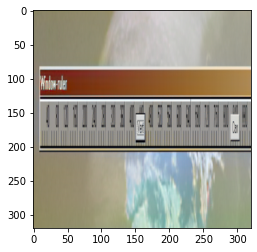

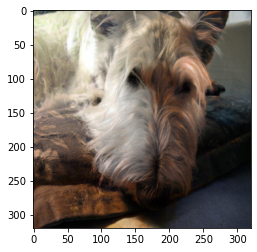

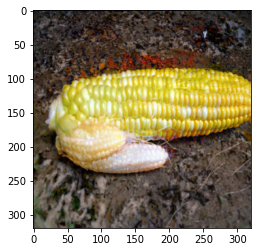

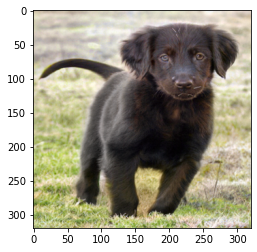

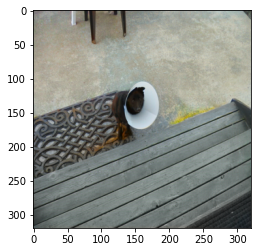

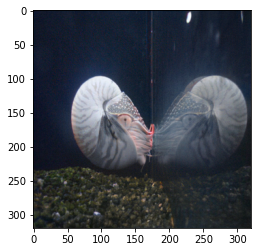

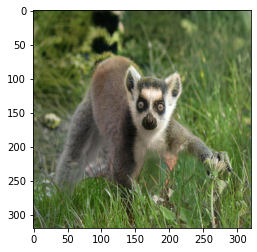

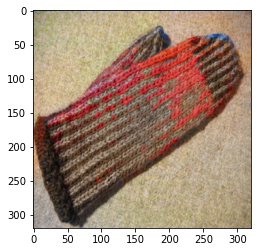

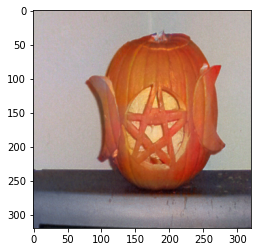

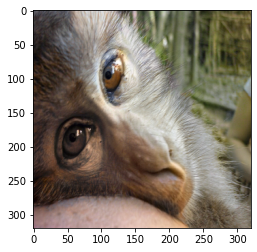

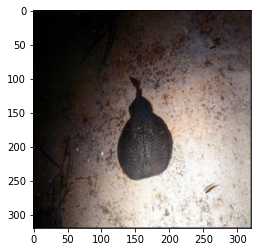

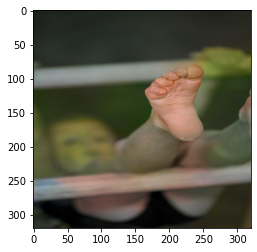

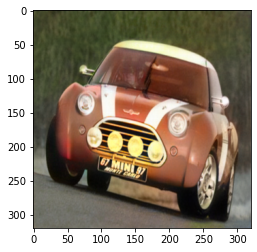

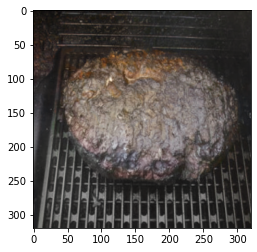

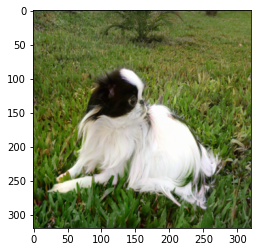

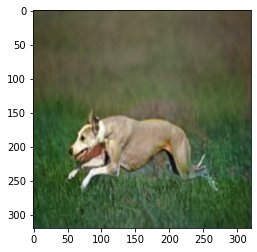

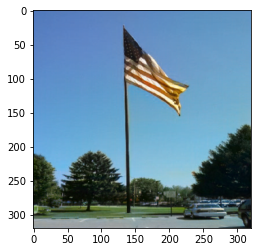

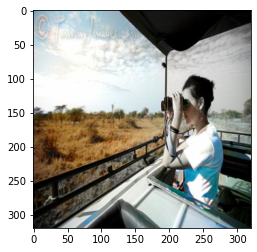

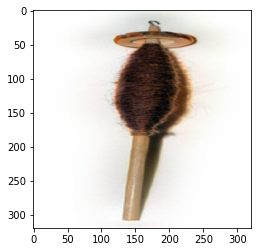

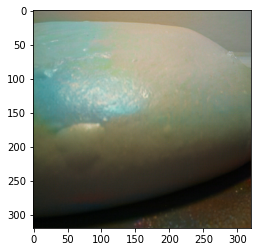

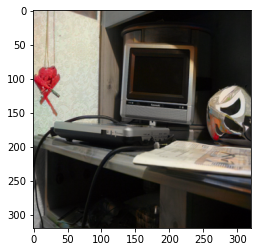

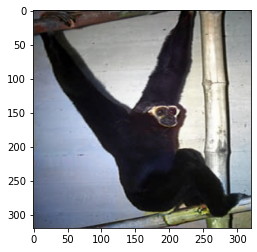

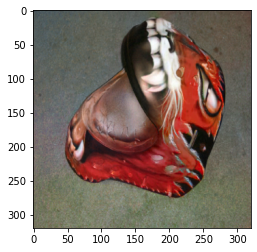

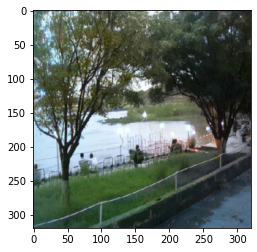

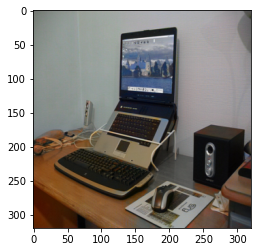

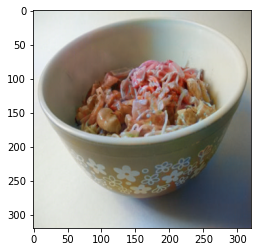

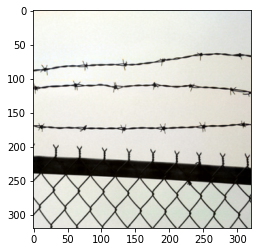

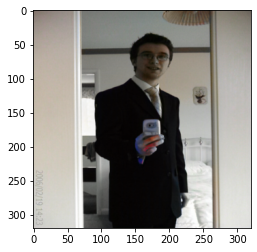

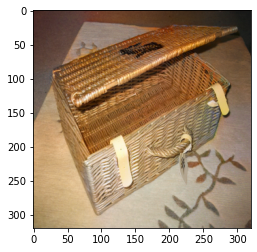

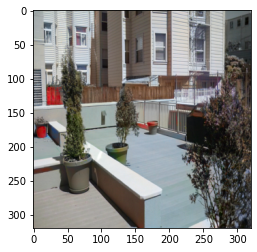

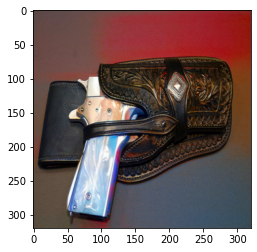

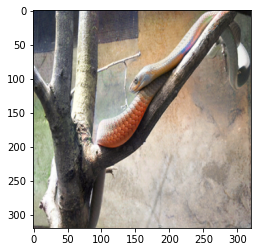

In [ ]:
for image in predictions[0]:
  plt.imshow(image)
  plt.show()